<a href="https://colab.research.google.com/github/mParthSaharanf/Equitable-Post-Transplant-Survival-Prediction-/blob/main/hct_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install --upgrade torch torchvision torchaudio


In [3]:
train_path = '/content/drive/MyDrive/Data_HCT/train.csv'
test_path = '/content/drive/MyDrive/Data_HCT/test.csv'

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

train_path = '/content/drive/MyDrive/Data_HCT/train.csv'
test_path = '/content/drive/MyDrive/Data_HCT/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (28800, 60)
Test shape: (3, 58)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


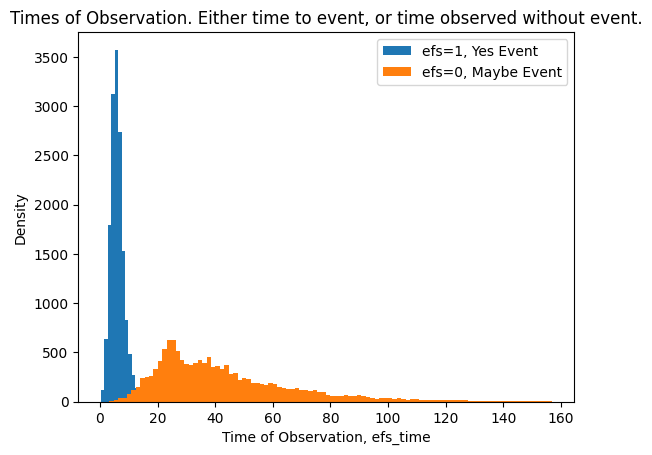

In [5]:
plt.hist(train.loc[train.efs==1, "efs_time"], bins=100, label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0, "efs_time"], bins=100, label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

In [6]:
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1, "efs_time"].max()
mn = train.loc[train.efs==0, "efs_time"].min()
train.loc[train.efs==0, "y"] = train.loc[train.efs==0, "y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs==0, "y"] += 2*len(train)
train.y = train.y / train.y.max()
train.y = np.log(train.y)
train.y -= train.y.mean()
train.y *= -1.0

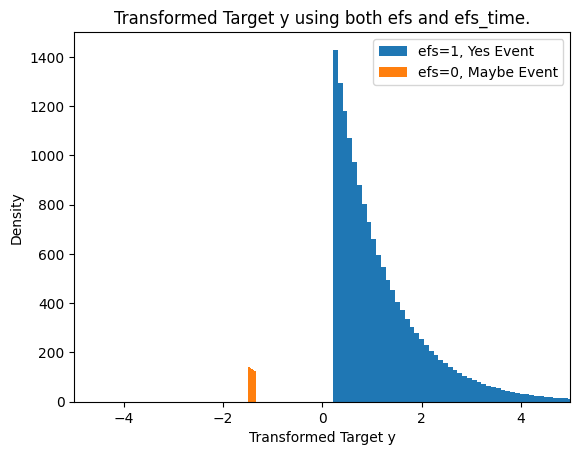

In [7]:
plt.hist(train.loc[train.efs==1, "y"], bins=100, label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0, "y"], bins=100, label="efs=0, Maybe Event")
plt.xlim((-5, 5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [8]:
RMV = ["ID", "efs", "efs_time", "y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [9]:
CATS = []
for c in FEATURES:
    if train[c].dtype == "object":
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        CATS.append(c)
    elif not "age" in c:
        train[c] = train[c].astype("str")
        test[c] = test[c].astype("str")
        CATS.append(c)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [10]:
CAT_SIZE = []
CAT_EMB = []
NUMS = []

combined = pd.concat([train, test], axis=0, ignore_index=True)

print("We LABEL ENCODE the CATEGORICAL FEATURES: ")

for c in FEATURES:
    if c in CATS:
        # LABEL ENCODE
        combined[c], _ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")

        n = combined[c].nunique()
        mn = combined[c].min()
        mx = combined[c].max()
        print(f'{c} has ({n}) unique values')

        CAT_SIZE.append(mx+1)
        CAT_EMB.append(int(np.ceil(np.sqrt(mx+1))))
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

        m = combined[c].mean()
        s = combined[c].std()
        combined[c] = (combined[c]-m)/s
        combined[c] = combined[c].fillna(0)

        NUMS.append(c)

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()


We LABEL ENCODE the CATEGORICAL FEATURES: 
dri_score has (12) unique values
psych_disturb has (4) unique values
cyto_score has (8) unique values
diabetes has (4) unique values
hla_match_c_high has (4) unique values
hla_high_res_8 has (8) unique values
tbi_status has (8) unique values
arrhythmia has (4) unique values
hla_low_res_6 has (6) unique values
graft_type has (2) unique values
vent_hist has (3) unique values
renal_issue has (4) unique values
pulm_severe has (4) unique values
prim_disease_hct has (18) unique values
hla_high_res_6 has (7) unique values
cmv_status has (5) unique values
hla_high_res_10 has (9) unique values
hla_match_dqb1_high has (4) unique values
tce_imm_match has (9) unique values
hla_nmdp_6 has (6) unique values
hla_match_c_low has (4) unique values
rituximab has (3) unique values
hla_match_drb1_low has (3) unique values
hla_match_dqb1_low has (4) unique values
prod_type has (2) unique values
cyto_score_detail has (6) unique values
conditioning_intensity has (7)

In [11]:
class TabularDataset(Dataset):
    def __init__(self, cat_data, num_data, targets=None):
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        if targets is not None:
            self.targets = torch.tensor(targets, dtype=torch.float32)
        else:
            self.targets = None

    def __len__(self):
        return len(self.cat_data)

    def __getitem__(self, idx):
        if self.targets is not None:
            return self.cat_data[idx], self.num_data[idx], self.targets[idx]
        else:
            return self.cat_data[idx], self.num_data[idx]


In [12]:
class TabularModel(nn.Module):
    def __init__(self, cat_sizes, emb_sizes, num_features):
        super().__init__()

        # Embedding layers for categorical features
        self.emb_layers = nn.ModuleList([
            nn.Embedding(cat_size, emb_size)
            for cat_size, emb_size in zip(cat_sizes, emb_sizes)
        ])

        # Calculate total size after embeddings
        total_emb_size = sum(emb_sizes)

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(total_emb_size + num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, cat_x, num_x):
        # Process categorical features through embeddings
        embs = [emb_layer(cat_x[:, i]) for i, emb_layer in enumerate(self.emb_layers)]

        # Concatenate all embeddings
        cat_features = torch.cat(embs, dim=1)

        # Concatenate with numerical features
        x = torch.cat([cat_features, num_x], dim=1)

        # Pass through fully connected layers
        return self.fc_layers(x)


In [13]:
EPOCHS = 4
BATCH_SIZE = 512
REPEATS = 3
FOLDS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cpu


Learning rate schedule: 0.01 to 0.01 to 0.0001


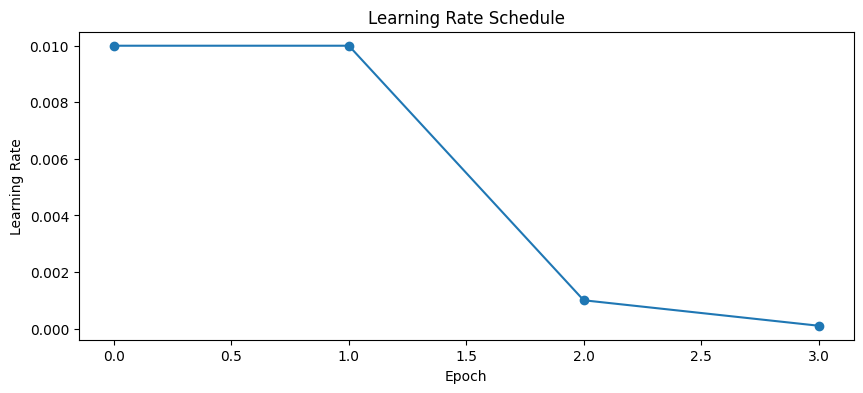

In [14]:
LRS = [0.01]*2 + [0.001]*1 + [0.0001]*1

rng = [i for i in range(EPOCHS)]
lr_y = [LRS[x] for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

In [15]:
kf = KFold(n_splits=FOLDS, random_state=42, shuffle=True)

oof_nn = np.zeros(len(train))
pred_nn = np.zeros(len(test))

for r in range(REPEATS):
    VERBOSE = r == 0
    print("#"*25)
    print(f"### REPEAT {r+1} ###")
    print("#"*25)

    for i, (train_index, test_index) in enumerate(kf.split(train)):
        if VERBOSE:
            print(" ", "#"*25)
            print(" ", f"### Fold {i+1} ###")
            print(" ", "#"*25)

        X_train_cats = train.loc[train_index, CATS].values
        X_train_nums = train.loc[train_index, NUMS].values
        y_train = train.loc[train_index, "y"].values.reshape(-1, 1)

        X_valid_cats = train.loc[test_index, CATS].values
        X_valid_nums = train.loc[test_index, NUMS].values
        y_valid = train.loc[test_index, "y"].values.reshape(-1, 1)

        X_test_cats = test[CATS].values
        X_test_nums = test[NUMS].values

        # Create datasets and dataloaders
        train_dataset = TabularDataset(X_train_cats, X_train_nums, y_train)
        valid_dataset = TabularDataset(X_valid_cats, X_valid_nums, y_valid)
        test_dataset = TabularDataset(X_test_cats, X_test_nums)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Initialize model
        model = TabularModel(CAT_SIZE, CAT_EMB, len(NUMS)).to(DEVICE)
        criterion = nn.MSELoss()

        # Training loop
        for epoch in range(EPOCHS):
            # Set learning rate for this epoch
            optimizer = optim.Adam(model.parameters(), lr=LRS[epoch])

            # Training
            model.train()
            train_loss = 0
            for cat_x, num_x, y in train_loader:
                cat_x, num_x, y = cat_x.to(DEVICE), num_x.to(DEVICE), y.to(DEVICE)

                optimizer.zero_grad()
                outputs = model(cat_x, num_x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * cat_x.size(0)

            train_loss /= len(train_loader.dataset)

            # Validation
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for cat_x, num_x, y in valid_loader:
                    cat_x, num_x, y = cat_x.to(DEVICE), num_x.to(DEVICE), y.to(DEVICE)
                    outputs = model(cat_x, num_x)
                    loss = criterion(outputs, y)
                    valid_loss += loss.item() * cat_x.size(0)

            valid_loss /= len(valid_loader.dataset)

            if VERBOSE:
                print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        # Predict OOF
        model.eval()
        valid_preds = []
        with torch.no_grad():
            for cat_x, num_x, _ in valid_loader:
                cat_x, num_x = cat_x.to(DEVICE), num_x.to(DEVICE)
                outputs = model(cat_x, num_x)
                valid_preds.append(outputs.cpu().numpy())

        valid_preds = np.vstack(valid_preds).flatten()
        oof_nn[test_index] += valid_preds

        # Predict test
        test_preds = []
        with torch.no_grad():
            for cat_x, num_x in test_loader:
                cat_x, num_x = cat_x.to(DEVICE), num_x.to(DEVICE)
                outputs = model(cat_x, num_x)
                test_preds.append(outputs.cpu().numpy())

        test_preds = np.vstack(test_preds).flatten()
        pred_nn += test_preds / (FOLDS * REPEATS)

oof_nn /= REPEATS

#########################
### REPEAT 1 ###
#########################
  #########################
  ### Fold 1 ###
  #########################
Epoch 1/4, Train Loss: 2.3319, Valid Loss: 1.9765
Epoch 2/4, Train Loss: 1.9391, Valid Loss: 1.8959
Epoch 3/4, Train Loss: 1.8539, Valid Loss: 1.8988
Epoch 4/4, Train Loss: 1.8391, Valid Loss: 1.8884
  #########################
  ### Fold 2 ###
  #########################
Epoch 1/4, Train Loss: 2.6028, Valid Loss: 1.9821
Epoch 2/4, Train Loss: 2.0019, Valid Loss: 1.9854
Epoch 3/4, Train Loss: 1.8732, Valid Loss: 1.8986
Epoch 4/4, Train Loss: 1.8541, Valid Loss: 1.8944
  #########################
  ### Fold 3 ###
  #########################
Epoch 1/4, Train Loss: 2.2929, Valid Loss: 1.9763
Epoch 2/4, Train Loss: 1.9580, Valid Loss: 1.8997
Epoch 3/4, Train Loss: 1.8566, Valid Loss: 1.8808
Epoch 4/4, Train Loss: 1.8348, Valid Loss: 1.8793
  #########################
  ### Fold 4 ###
  #########################
Epoch 1/4, Train Loss: 2.3973, Valid Lo

In [16]:
import numpy as np

def simple_concordance_index(times, scores, events):
    """
    A simplified concordance index calculation.

    Parameters:
    times: Array of event/censoring times
    scores: Array of predicted risk scores (higher = higher risk)
    events: Array of event indicators (1=event occurred, 0=censored)

    Returns:
    float: Concordance index
    """
    # Convert inputs to numpy arrays
    times = np.array(times)
    scores = np.array(scores)
    events = np.array(events)

    # Only consider samples where the event occurred
    event_indices = np.where(events == 1)[0]

    if len(event_indices) == 0:
        return 0.5  # No events, return random prediction score

    concordant_pairs = 0
    total_pairs = 0

    # For each sample where event occurred
    for i in event_indices:
        # Find all samples with longer times
        comparable_indices = np.where(times > times[i])[0]

        if len(comparable_indices) == 0:
            continue

        # Count concordant pairs (higher risk score for shorter survival)
        concordant = np.sum(scores[i] > scores[comparable_indices])
        # Count ties
        ties = np.sum(scores[i] == scores[comparable_indices])

        # Add to totals
        total_pairs += len(comparable_indices)
        concordant_pairs += concordant + 0.5 * ties

    # Return concordance index
    return concordant_pairs / total_pairs if total_pairs > 0 else 0.5

def calculate_cv_score(train_df, predictions):
    """
    Calculate CV score across race groups

    Parameters:
    train_df: DataFrame with true values
    predictions: Array of predictions

    Returns:
    float: CV score
    """
    # Create a copy to avoid modifying the original
    df = train_df.copy()
    df['prediction'] = predictions

    # Calculate concordance index for each race group
    race_groups = df['race_group'].unique()
    c_indices = []

    for race in race_groups:
        race_df = df[df['race_group'] == race]
        c_index = simple_concordance_index(
            race_df['efs_time'],
            race_df['prediction'],  # Higher prediction = higher risk
            race_df['efs']
        )
        c_indices.append(c_index)
        print(f"C-index for {race}: {c_index:.4f}")

    # Calculate mean and standard deviation
    mean_c_index = np.mean(c_indices)
    std_c_index = np.std(c_indices)

    # Final score: mean - std
    final_score = mean_c_index - std_c_index

    print(f"Mean C-index: {mean_c_index:.4f}")
    print(f"Std C-index: {std_c_index:.4f}")

    return final_score

# Calculate CV score
cv_score = calculate_cv_score(train, oof_nn)
print(f"\nOverall CV for NN = {cv_score:.6f}")



C-index for 0: 0.6810
C-index for 1: 0.6891
C-index for 2: 0.6590
C-index for 3: 0.6798
C-index for 4: 0.6700
C-index for 5: 0.6656
Mean C-index: 0.6741
Std C-index: 0.0102

Overall CV for NN = 0.663901
